In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence,plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle 
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
BASE_DIR = './weather_Dataset'
WORKING_DIR = './'

In [4]:

Weather_data = pd.read_csv('./Weather_Dataset/rain_temp_data.csv')
# Weather_data = Weather_data.drop('Unnamed: 0', axis=1)
# Weather_data = Weather_data.drop('0', axis=1)
Weather_data.head()

,prep,high_temp,avg_temp,low_temp,Labels
0,1.016,25.555556,22.222222,23.888889,1000268201_693b08cb0e.jpg
1,2.540,26.111111,22.222222,24.444444,1001773457_577c3a7d70.jpg
2,2.540,26.666667,22.222222,24.444444,1002674143_1b742ab4b8.jpg
3,3.556,26.666667,22.222222,24.444444,1003163366_44323f5815.jpg
4,3.556,25.555556,21.666667,23.333333,1007129816_e794419615.jpg


In [5]:
with open(os.path.join(BASE_DIR, 'captions.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # print("--> ", line)
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 6526/6526 [00:00<00:00, 293987.80it/s]


In [71]:
# len(mapping)
# mapping

1305

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [8]:
mapping["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [9]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [10]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

3684

In [11]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

In [12]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
image_ids[:10]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a']

In [13]:
with open(os.path.join(BASE_DIR, 'rain_temp_data.csv'), 'r') as f:
    next(f)
    features_weathers = f.read()

features_weathers

'1.016,25.55555556,22.22222222,23.88888889,1000268201_693b08cb0e.jpg\n2.54,26.11111111,22.22222222,24.44444444,1001773457_577c3a7d70.jpg\n2.54,26.66666667,22.22222222,24.44444444,1002674143_1b742ab4b8.jpg\n3.556,26.66666667,22.22222222,24.44444444,1003163366_44323f5815.jpg\n3.556,25.55555556,21.66666667,23.33333333,1007129816_e794419615.jpg\n0.508,24.44444444,22.22222222,23.33333333,1007320043_627395c3d8.jpg\n0.254,25.55555556,17.77777778,21.66666667,1009434119_febe49276a.jpg\n0.508,23.88888889,20.55555556,22.22222222,1012212859_01547e3f17.jpg\n0.254,32.77777778,20,23.33333333,1015118661_980735411b.jpg\n0.254,27.22222222,21.11111111,24.44444444,1015584366_dfcec3c85a.jpg\n0.254,27.22222222,22.22222222,25,101654506_8eb26cfb60.jpg\n1.778,27.22222222,21.11111111,24.44444444,101669240_b2d3e7f17b.jpg\n0.254,26.66666667,21.66666667,24.44444444,1016887272_03199f49c4.jpg\n1.016,27.77777778,22.77777778,25.55555556,1019077836_6fc9b15408.jpg\n0.254,26.11111111,23.33333333,25,1019604187_d087bf9a5f.

In [14]:
# create mapping of image to captions
feature_1 = {}
# process lines
for line in tqdm(features_weathers.split('\n')):
    # print("--> ", line)
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[len(tokens)-1], tokens[:len(tokens)-2]
    # print( image_id, caption)
    weather_raw_info = []
    for item in caption:
        weather_raw_info.append(float(item))
        
    # print(weather_raw_info)
   
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    # create list if needed
    if image_id not in feature_1:
        feature_1[image_id] = []
    # store the caption
        
    weather_raw_info_nd_array = np.asarray(weather_raw_info)
    # print(weather_raw_info_nd_array)
    feature_1[image_id].append(np.asarray(weather_raw_info_nd_array))

type(feature_1['1000268201_693b08cb0e']),len(feature_1['1000268201_693b08cb0e'])

100%|██████████| 1306/1306 [00:00<00:00, 141489.37it/s]


(list, 1)

In [15]:
feature_1['1000268201_693b08cb0e']

[array([ 1.016     , 25.55555556, 22.22222222])]

In [16]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

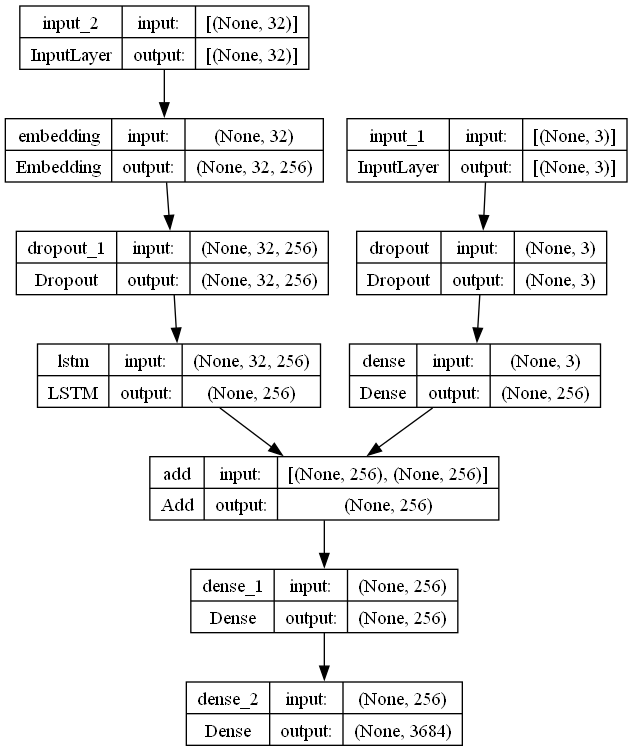

In [17]:
# encoder model
# image feature layers
inputs1 = Input(shape=(3,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 256)              943104    ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 3)                    0         ['input_1[0][0]']             
                                                                                              

In [19]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, feature_1, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


36/36 [==============================] - 70s 2s/step - loss: 3.6888


In [ ]:
# save the model
# model.save(WORKING_DIR+'/best_model.h5')

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # print(sequence)
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        image = np.asarray(image, dtype=np.float32)
        # print(type(image), type(sequence) )
        
        # predict next word
        yhat = model.predict([image, sequence], verbose=1)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

# validate with test data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]   
    y_pred = predict_caption(model, feature_1[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/131 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 1/131 [00:03<06:33,  3.03s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 2/131 [00:03<03:51,  1.79s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 3/131 [00:04<02:58,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 4/131 [00:05<02:35,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 5/131 [00:06<02:19,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 6/131 [00:07<02:11,  1.05s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 7/131 [00:08<02:06,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 8/131 [00:09<02:10,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 9/131 [00:10<02:03,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 10/131 [00:11<02:03,  1.02s/it]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 11/131 [00:12<02:01,  1.01s/it]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 12/131 [00:13<01:55,  1.03it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 13/131 [00:14<01:52,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 14/131 [00:15<01:49,  1.07it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 15/131 [00:16<01:49,  1.06it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 16/131 [00:17<01:48,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 17/131 [00:18<01:45,  1.08it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▎        | 18/131 [00:19<01:46,  1.06it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 19/131 [00:20<01:52,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 20/131 [00:21<01:48,  1.02it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 21/131 [00:22<01:48,  1.01it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 22/131 [00:23<01:45,  1.03it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 23/131 [00:24<01:45,  1.02it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 24/131 [00:25<01:44,  1.02it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 25/131 [00:26<01:41,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 26/131 [00:27<01:40,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 27/131 [00:27<01:36,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 28/131 [00:29<01:44,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 29/131 [00:30<01:40,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 30/131 [00:30<01:36,  1.05it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 31/131 [00:31<01:35,  1.05it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 32/131 [00:32<01:37,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 33/131 [00:33<01:35,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 34/131 [00:34<01:32,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 35/131 [00:35<01:37,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 36/131 [00:36<01:33,  1.02it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 37/131 [00:37<01:30,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 38/131 [00:38<01:28,  1.05it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 39/131 [00:39<01:27,  1.05it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 40/131 [00:40<01:26,  1.05it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 41/131 [00:41<01:23,  1.08it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 42/131 [00:42<01:24,  1.05it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 43/131 [00:43<01:24,  1.04it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 44/131 [00:44<01:23,  1.04it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 45/131 [00:45<01:22,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 46/131 [00:46<01:21,  1.04it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 47/131 [00:47<01:19,  1.05it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 48/131 [00:48<01:18,  1.05it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 49/131 [00:49<01:17,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 50/131 [00:50<01:16,  1.06it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 51/131 [00:51<01:16,  1.05it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 52/131 [00:51<01:13,  1.08it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 53/131 [00:52<01:12,  1.08it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 54/131 [00:53<01:12,  1.07it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 55/131 [00:54<01:11,  1.06it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 56/131 [00:55<01:14,  1.00it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 57/131 [00:56<01:12,  1.03it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 58/131 [00:57<01:09,  1.05it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 59/131 [00:58<01:12,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 60/131 [01:00<01:14,  1.05s/it]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 61/131 [01:00<01:10,  1.01s/it]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 62/131 [01:01<01:07,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 63/131 [01:02<01:09,  1.03s/it]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 64/131 [01:03<01:06,  1.01it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 65/131 [01:04<01:02,  1.05it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 66/131 [01:05<01:02,  1.04it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 67/131 [01:06<01:01,  1.04it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 68/131 [01:07<00:59,  1.05it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 69/131 [01:08<00:58,  1.07it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 70/131 [01:09<00:56,  1.07it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 71/131 [01:10<00:56,  1.06it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 72/131 [01:11<00:56,  1.04it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 73/131 [01:12<00:59,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 74/131 [01:13<00:57,  1.00s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 75/131 [01:14<00:55,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 76/131 [01:15<00:56,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 77/131 [01:16<00:58,  1.07s/it]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 78/131 [01:18<01:00,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 79/131 [01:19<00:58,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 80/131 [01:20<00:55,  1.09s/it]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 81/131 [01:21<00:53,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 82/131 [01:21<00:48,  1.01it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 83/131 [01:23<00:48,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 84/131 [01:23<00:46,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 85/131 [01:24<00:44,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 86/131 [01:25<00:42,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 87/131 [01:26<00:43,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 88/131 [01:27<00:41,  1.04it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 89/131 [01:28<00:41,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 90/131 [01:29<00:38,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 91/131 [01:30<00:37,  1.06it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 92/131 [01:31<00:39,  1.02s/it]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 93/131 [01:32<00:38,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 94/131 [01:33<00:37,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 95/131 [01:34<00:35,  1.02it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 96/131 [01:35<00:33,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 97/131 [01:36<00:31,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 98/131 [01:37<00:32,  1.02it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 99/131 [01:38<00:31,  1.03it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 100/131 [01:39<00:30,  1.02it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 101/131 [01:40<00:30,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 102/131 [01:41<00:29,  1.01s/it]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 103/131 [01:42<00:29,  1.04s/it]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 104/131 [01:43<00:27,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 105/131 [01:44<00:26,  1.01s/it]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 106/131 [01:45<00:24,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 107/131 [01:46<00:23,  1.01it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 108/131 [01:47<00:23,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 109/131 [01:48<00:22,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 110/131 [01:49<00:21,  1.00s/it]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 111/131 [01:50<00:19,  1.01it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 112/131 [01:51<00:18,  1.02it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 113/131 [01:52<00:17,  1.00it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 114/131 [01:53<00:16,  1.00it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 115/131 [01:54<00:15,  1.02it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 116/131 [01:55<00:14,  1.01it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 117/131 [01:56<00:14,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 118/131 [01:57<00:13,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 119/131 [01:58<00:12,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 120/131 [02:00<00:12,  1.12s/it]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 121/131 [02:01<00:11,  1.11s/it]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 122/131 [02:02<00:09,  1.10s/it]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 123/131 [02:03<00:08,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 124/131 [02:04<00:07,  1.07s/it]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 125/131 [02:05<00:06,  1.08s/it]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 126/131 [02:06<00:05,  1.08s/it]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 127/131 [02:07<00:04,  1.08s/it]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 128/131 [02:08<00:03,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 129/131 [02:09<00:02,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 130/131 [02:10<00:01,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 131/131 [02:12<00:00,  1.01s/it]

BLEU-1: 0.493743
BLEU-2: 0.232608


In [22]:
def generate_caption(feature_id):
    
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, feature_1[feature_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
generate_caption("2245914678_1f82fc3d80")

---------------------Actual---------------------
startseq girl with dyed red hair wearing striped clothing talking on cellphone endseq
startseq girl with read dreadlocks is talking on the phone endseq
startseq red haired girl with black and white striped shirt talking on cellphone endseq
startseq woman with bright red hair and striped clothing talks on phone endseq
startseq woman with red hair and black striped shirt talking on the phone endseq
1/1 [==============================] - 0s 39ms/step
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


In [89]:
feature_1['2245914678_1f82fc3d80']

[array([1304.  ,   99.  ,   88.  ,   77.  ,   66.  ,   61.  ,   54.  ,
          64.  ,   43.  ,   22.  ,   30.04,   29.97,   29.91,   10.  ,
          10.  ,   10.  ,   12.  ,    4.  ])]

In [24]:
generate_caption("101654506_8eb26cfb60")

---------------------Actual---------------------
startseq girl with dyed red hair wearing striped clothing talking on cellphone endseq
startseq girl with read dreadlocks is talking on the phone endseq
startseq red haired girl with black and white striped shirt talking on cellphone endseq
startseq woman with bright red hair and striped clothing talks on phone endseq
startseq woman with red hair and black striped shirt talking on the phone endseq
1/1 [==============================] - 0s 44ms/step
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq
